In [1]:
"""
The classic game of flappy bird. Make with python
and pygame. Features pixel perfect collision using masks :o
Date Modified:  Jul 30, 2019
Author: Tech With Tim
Estimated Work Time: 5 hours (1 just for that damn collision)
"""
import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
Agent_number_n=5;
Alpha = (1-0.714);

global temp_list
temp_list = []
def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    
    training_data.append(temp_list)
    training_label.append(S)
    

def read_training_data():
    for i in range(50000):
        appen_train(np.random.rand(Agent_number_n));

training_data=[]
training_label=[]
S=1.0
read_training_data();

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    

def read_testing_data():
#     devided=20
#     for i1 in range(devided+1):
#         for i2 in range(i1+1):
#             for i3 in range(i2+1):
#                 appen_test(i1/devided,i2/devided,i3/devided);
    for i in range(50000):
        appen_test(np.random.rand(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

In [3]:
training_data=np.array(training_data)
training_label=np.array(training_label)
testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(training_data)
print(testing_data)
print(training_label)
print(testing_label)

[[[0.99451661 0.69444983 0.13090843 0.40424579]
  [0.12953454 0.69444983 0.13090843 0.40424579]
  [0.12953454 0.99451661 0.13090843 0.40424579]
  [0.12953454 0.99451661 0.69444983 0.40424579]
  [0.12953454 0.99451661 0.69444983 0.13090843]]

 [[0.96801303 0.66263786 0.74611973 0.82753793]
  [0.15905444 0.66263786 0.74611973 0.82753793]
  [0.15905444 0.96801303 0.74611973 0.82753793]
  [0.15905444 0.96801303 0.66263786 0.82753793]
  [0.15905444 0.96801303 0.66263786 0.74611973]]

 [[0.67141364 0.73029759 0.45394338 0.20057211]
  [0.94243457 0.73029759 0.45394338 0.20057211]
  [0.94243457 0.67141364 0.45394338 0.20057211]
  [0.94243457 0.67141364 0.73029759 0.20057211]
  [0.94243457 0.67141364 0.73029759 0.45394338]]

 ...

 [[0.79642545 0.24068377 0.00172007 0.13340626]
  [0.67853101 0.24068377 0.00172007 0.13340626]
  [0.67853101 0.79642545 0.00172007 0.13340626]
  [0.67853101 0.79642545 0.24068377 0.13340626]
  [0.67853101 0.79642545 0.24068377 0.00172007]]

 [[0.7603578  0.36429126 0

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)


cuda:0


In [5]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
        

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n-1
        num_hidden = 100
        num_output = 1

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_3 = torch.nn.Linear(num_hidden, num_hidden)
        self.output_allocation = torch.nn.Linear(num_hidden, num_output)

    def calculate(self, value_list):
        h1 = torch.relu_(self.hidden_0(value_list))
        h2 = torch.relu_(self.hidden_1(h1))
        h3 = torch.relu_(self.hidden_2(h2))
        h4 = torch.relu_(self.hidden_3(h3))
        h = torch.relu(self.output_allocation(h4))

        return h

    def forward(self, input_list,input_label):
        global iteration,echo
        loss1 = 0
        loss2 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).cuda().type(torch.float32)
        h_list = []
        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            h_list.append(h)
        
        input_label = torch.from_numpy(
            np.array(input_label)).cuda().type(torch.float32)
        sum_h = torch.sum(torch.cat(h_list)).cuda()
        
        
        loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                        torch.square((Agent_number_n-1)*input_label-sum_h),
                        torch.zeros(1).cuda()
                      )

        loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                        torch.square(sum_h-(Agent_number_n-Alpha)*input_label),
                        torch.zeros(1).cuda()
                      )
                      

        return loss1,loss2,h_list

In [6]:
random.seed(2000)
torch.manual_seed(256)
net  = Net()
net.apply(weight_init)

net = torch.load("save/Deep_learning_5")
net.to(dev)

Net(
  (hidden_0): Linear(in_features=4, out_features=100, bias=True)
  (hidden_1): Linear(in_features=100, out_features=100, bias=True)
  (hidden_2): Linear(in_features=100, out_features=100, bias=True)
  (hidden_3): Linear(in_features=100, out_features=100, bias=True)
  (output_allocation): Linear(in_features=100, out_features=1, bias=True)
)

In [7]:
#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.00001)
optimizer = opt.Adam(net.parameters(), lr=0.00005)

batch_size = 128
echo = 10

In [8]:
for iteration in range(int(echo)):
    # offender_types = []
    # defender_types = []
    
    
    X_train_list = []
    temp_number = 0
    total_batch_loss = 0 
    while(temp_number<len(training_data)-1):
        loss2_list = []
        loss1_sum = 0
        loss2_sum = 0
        denominator = 0
        for index in range(temp_number, min(batch_size+temp_number,len(training_data))):
            h_loss1,h_loss2,h_list = net(training_data[index],training_label[index])
            denominator += 1
            loss1_sum += h_loss1
            loss2_sum += h_loss2
            
        loss_sum = loss1_sum + loss2_sum
        loss = (loss_sum) / denominator 
        total_batch_loss +=float(loss_sum)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        temp_number = index
        
        if(random.random()<=0.02):
            print(temp_number,loss,float(loss1_sum),float(loss2_sum))


    print("batch iteration", iteration)
    print("batch_loss: %.2f " % (total_batch_loss/len(training_data)))
    
    print()

6096 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
6858 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
8763 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
10414 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
11811 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
17907 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
23114 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
26416 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
29337 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
32512 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
33401 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
49149 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
batch iteration 0
batch_loss: 0.00 

381 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
3302 tensor([0.], device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
18669 tensor([0.]

In [9]:
torch.save(net, "save/Deep_learning_5")

In [10]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = net.calculate(torch.tensor(testing_data[index][i]).cuda().type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    



In [11]:
print(max(result_list),min(result_list),max(result_list)-min(result_list))

4.676860570907593 4.080184578895569 0.5966759920120239


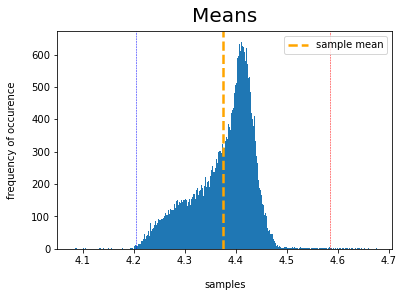

In [12]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.001)], linestyle='--', linewidth=0.5, label="0.1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.999)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()